First, I import *all* of the libraries I need.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
import sklearn.datasets as datasets
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from pprint import pprint
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, auc, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from helperfxns import *
from sklearn.model_selection import KFold

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
df = pd.read_csv('bk_data.csv', index_col=0)

In [4]:
df.drop(['BOROUGH','NEIGHBORHOOD','BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'YEAR_BUILT', 
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE',
       'zip_mean', 'above_mean'], axis=1, inplace=True)

In [5]:
print('Target Variable')
print(df.groupby(['above_bk_mean']).above_bk_mean.count())

Target Variable
above_bk_mean
0    12252
1     3178
Name: above_bk_mean, dtype: int64


For my model:

0 = below the mean,
1 = above the mean

I think for my model, if I'm someone that's looking at investing I would want to wrongly guess that it's above the mean (false positive = Type I error), because I would not want to wrongly buy a house thinking it was below the mean.
Be better at predicting the negatives!

**TYPE II ERRORS ARE THE BAD ONES (MINIMIZE FALSE NEGATIVES!)**

In [6]:
df = pd.get_dummies(df, columns=['SALE_SEASON','ZIP_CODE', 'APARTMENT_NUMBER', 'TAX_CLASS_AT_TIME_OF_SALE', 'year'], drop_first=True)

In [7]:
# Create matrix of features
X = df.drop('above_bk_mean', axis = 1) # grabs everything else but target

# Create target variable
y = df['above_bk_mean'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [34]:
X.columns = X.columns.str.replace(",", "_")

Now I'm going to train test split my data 75/25

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38)

#### Metrics used to evaluate my model:

**Classification Accuracy:** Overall, how often is the classifier correct?

I should check this against the null accuracy - how often it would be right if it always guessed yes.

**Precision**: When a positive value is predicted, how often is the prediction correct? i.e When it predicts that it is above the mean, how often is this correct?

**Recall(sensitivity)**: What proportion of the actual positives were identified correctly
- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall" 
**- I think this is what I want to maximize.**


**Specificity**: When the actual value is negative, how often is the prediction correct? When it *is* below the mean, how often is it right
How "specific" (or "selective") is the classifier in predicting positive instances?

**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect? - I want this to be low!

#### F1 Score
The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

In [9]:
# quick look at distribution of testing set
y_test.value_counts()

0    3022
1     836
Name: above_bk_mean, dtype: int64

In [10]:
# a quick look at logistic regression for some baseline insight into my data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix, without normalization
[[2961   61]
 [ 467  369]]


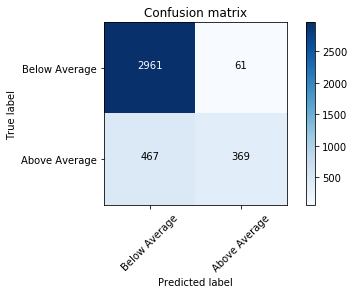

In [11]:
#visualize the confusion matrix (using one of my helper functions)
cm = confusion_matrix(y_test, y_pred)
classes = ["Below Average", "Above Average"]
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

Ok, this isn't terrible. Looks like quite a few type II errors though.

Lets look at all the metrics

In [12]:
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [13]:
# look at accuracy:
print(f'Classification Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# check null accuracy:
print(f'Null Accuracy: {max(y_test.mean(), 1 - y_test.mean())}')
# check precision
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
# check recall
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
# check specificity
print(f'Specificity: {(TN/float(TN+FP))}')
# check false positive rate
print(f'False Positive Rate: {FP/float(TN+FP)}')
# check F1
print(f'F1 Score: {(metrics.f1_score(y_test, y_pred))}')

Classification Accuracy: 0.8631415241057543
Null Accuracy: 0.7833074131674442
Precision: 0.858139534883721
Recall: 0.44138755980861244
Specificity: 0.9798146922567836
False Positive Rate: 0.02018530774321641
F1 Score: 0.5829383886255923


In [24]:
def print_eval_metrics(y_test, y_pred, y):
    # check null accuracy
    print(f'Null Accuracy: {max(y_test.mean(), 1 - y_test.mean())}')
    # Calculate Accuracy 
    acc = metrics.accuracy_score(y_test,y_pred) * 100
    print("Accuracy is :{0}".format(acc))
    # Calculate F1-Score 
    f1 = f1_score(y_test,y_pred)
    print("F1-Score is :{0}".format(f1))
    # Calculate Precision
    pre = metrics.precision_score(y_test, y_pred)
    print("Precision Score is :{0}".format(pre))
    # Calculate Recall
    recall = metrics.recall_score(y_test,y_pred)
    print("Recall Score is :{0}".format(recall))
    # Check the AUC for predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("\nAUC is :{0}".format(round(roc_auc,2)))
    # Create and print a confusion matrix 
    print('\nConfusion Matrix')
    print('----------------')
#     print(confusion_matrix(y_test, y_pred), y)
    cm = confusion_matrix(y_test, y_pred)
    classes = ["Below Average", "Above Average"]
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

**Optimize for precision &/or specificity**

# I'm going to 'SMOTE' my classes as they are very uneven

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm_train, y_sm_train = smote.fit_resample(X_train, y_train)

In [14]:
#repeat the logreg to see what happened
logreg = LogisticRegression()
logreg.fit(X_sm_train, y_sm_train)
y_pred = logreg.predict(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [16]:
# look at accuracy:
print(f'Classification Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# check null accuracy:
print(f'Null Accuracy: {max(y_test.mean(), 1 - y_test.mean())}')
# check precision
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
# check recall
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
# check specificity
print(f'Specificity: {(TN/float(TN+FP))}')
# check false positive rate
print(f'False Positive Rate: {FP/float(TN+FP)}')
# check F1
print(f'F1 Score: {(metrics.f1_score(y_test, y_pred))}')

Classification Accuracy: 0.7864178330741317
Null Accuracy: 0.7833074131674442
Precision: 0.5063157894736842
Recall: 0.5753588516746412
Specificity: 0.8448047650562541
False Positive Rate: 0.15519523494374587
F1 Score: 0.5386338185890257


# Scale my data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38)
scaler = StandardScaler()  
scaler.fit(X_train)

Xs_train = scaler.transform(X_train)  
Xs_test = scaler.transform(X_test)

# Building a decision tree.

In [48]:
# fitting my data to a decision tree classifier
ctree=DecisionTreeClassifier(max_depth = 25)
ctree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

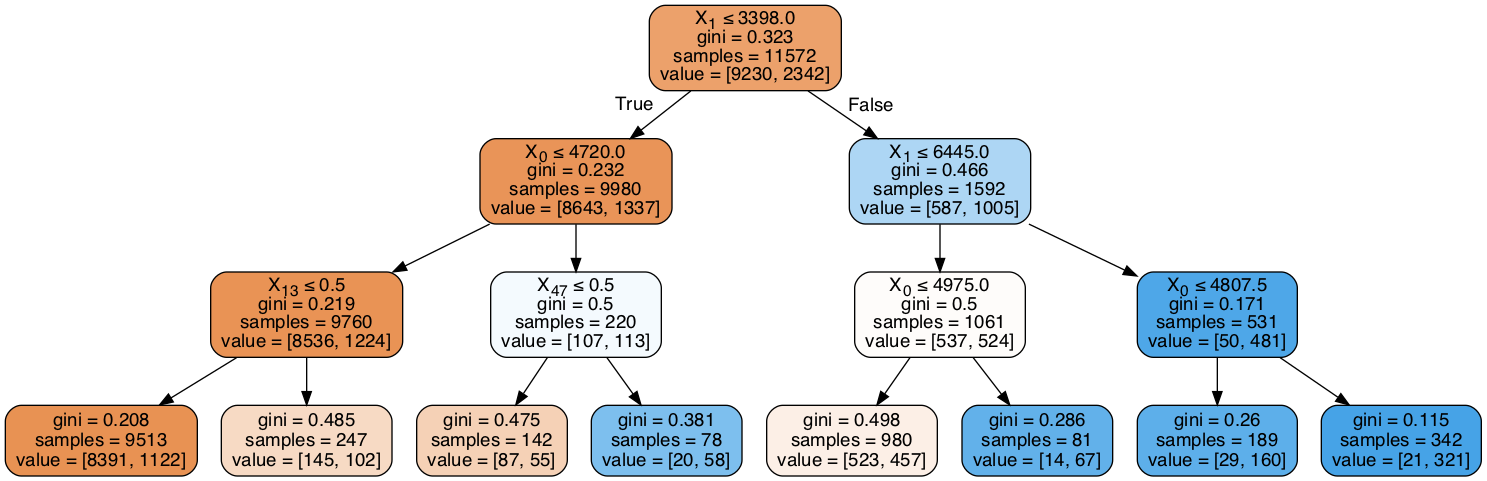

In [19]:
# visualizing my tree
dot_data = StringIO()
export_graphviz(ctree, out_file=dot_data,  
                rounded=True, filled=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [49]:
y_pred = ctree.predict(X_test)

Null Accuracy: 0.7833074131674442
Accuracy is :84.68118195956454
F1-Score is :0.5993220338983051
Precision Score is :0.6917057902973396
Recall Score is :0.5287081339712919

AUC is :0.73

Confusion Matrix
----------------
Confusion Matrix, without normalization
[[2825  197]
 [ 394  442]]


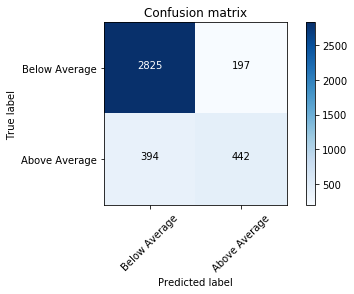

In [50]:
print_eval_metrics(y_test, y_pred, y)

I'm going to stop this here for now and jump to random forest as that was my best one and I really want to dig into that.

# Random Forest

In [15]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [16]:
# check the mean accuracy
print(f'Training accuracy: {forest.score(X_train, y_train)}')
print(f'Testing accuracy: {forest.score(X_test, y_test)}')

Training accuracy: 0.964828897338403
Testing accuracy: 0.8652151373768792


In [17]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

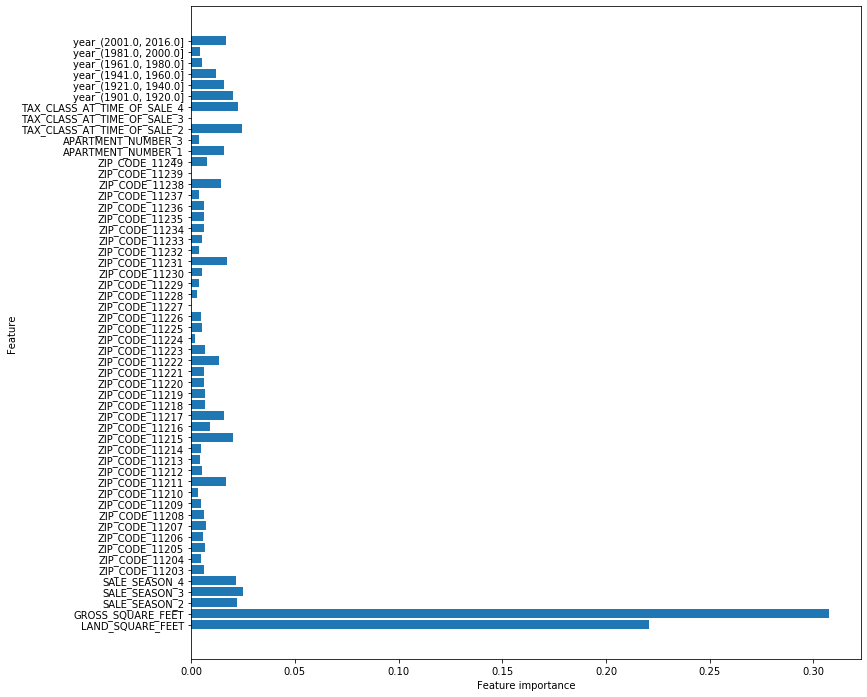

In [25]:
plot_feature_importances(forest)

In [27]:
# gridsearch to tune hyperparameters
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [28]:
# now I'll initialize my starting ranges
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 99, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [29]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                                                    n_jobs=None,
 

In [30]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 36,
 'bootstrap': True}

In [31]:
hyp_forest = RandomForestClassifier(n_estimators= 800, min_samples_split= 5, min_samples_leaf= 1, 
                                    max_features= 'sqrt', max_depth= 36, bootstrap= True, random_state=42)

In [32]:
hyp_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=36, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [33]:
# check the mean accuracy
print(f'Training accuracy: {hyp_forest.score(X_train, y_train)}')
print(f'Testing accuracy: {hyp_forest.score(X_test, y_test)}')

Training accuracy: 0.9358797096439682
Testing accuracy: 0.8722135821669259


In [72]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [25, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2,5,10],
    'n_estimators': [400, 600, 800, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [73]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [36]:
#with cv=3
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 800}

In [74]:
#with cv=5
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 400}

In [58]:
best_forest = RandomForestClassifier(n_estimators= 800, min_samples_split= 10, min_samples_leaf= 1, 
                                    max_features= 3, max_depth= 40, bootstrap= True, random_state=42)

In [59]:
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [60]:
# check the mean accuracy
print(f'Training accuracy: {best_forest.score(X_train, y_train)}')
print(f'Testing accuracy: {best_forest.score(X_test, y_test)}')

Training accuracy: 0.9179917041133772
Testing accuracy: 0.8701399688958009


In [21]:
print(f'Score improved with hyperparameter tuning by {round(100*((best_forest.score(X_test, y_test)-forest.score(X_test, y_test))/forest.score(X_test, y_test)),2)}%')

Score improved with hyperparameter tuning by 0.57%


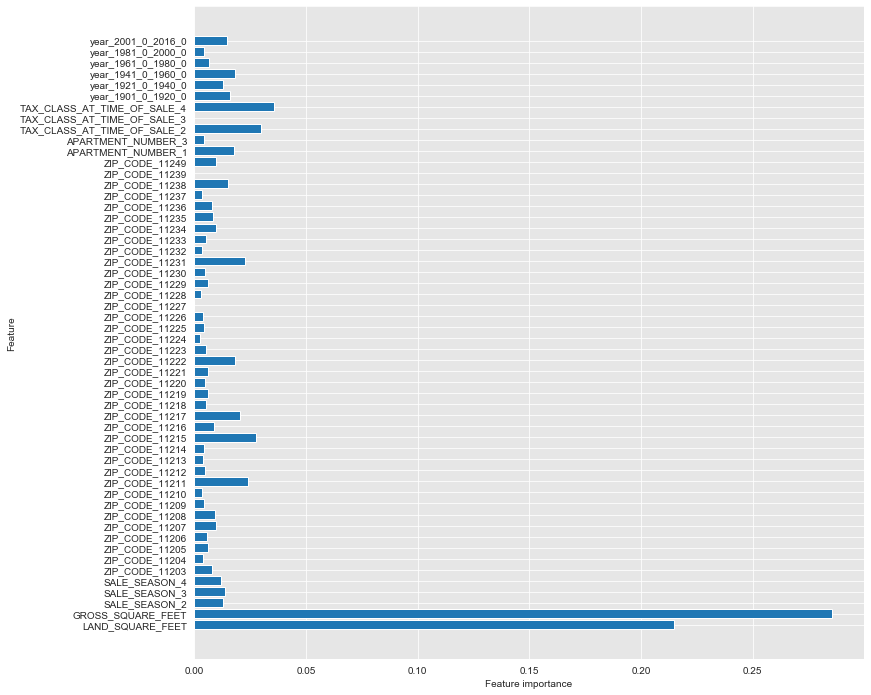

In [129]:
#have a look at the feature importance
plot_feature_importances(best_forest)

In [61]:
# testing predictions
pred = best_forest.predict(X_test)
# probabilities for each class
rf_probs = best_forest.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2891  131]
 [ 370  466]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3022
           1       0.78      0.56      0.65       836

    accuracy                           0.87      3858
   macro avg       0.83      0.76      0.79      3858
weighted avg       0.86      0.87      0.86      3858



Null Accuracy: 0.7833074131674442
Accuracy is :87.01399688958008
F1-Score is :0.6503838101884158
Precision Score is :0.7805695142378559
Recall Score is :0.5574162679425837

AUC is :0.76

Confusion Matrix
----------------
Confusion Matrix, without normalization
[[2891  131]
 [ 370  466]]


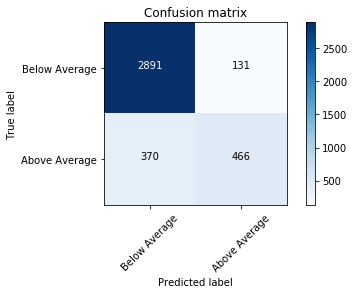

In [25]:
print_eval_metrics(y_test, pred, y)

In [62]:
print(rf_probs)

[0.00738756 0.9360164  0.00397886 ... 0.12616037 0.37924583 0.27475604]


Confusion Matrix, without normalization
[[2891  131]
 [ 370  466]]


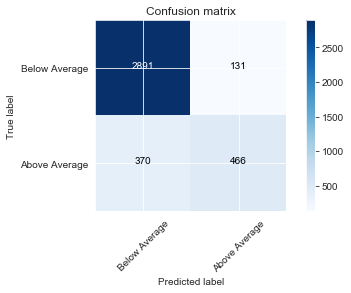

In [90]:
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

**Optimize for precision &/or specificity!**

Let's have a look at ROC and AUC

In [63]:
roc_value = roc_auc_score(y_test, rf_probs)
print(f'ROC Value:{roc_value}')

ROC Value:0.9178009588377417


In [68]:
#for various decision boundaries given the case member probabilites

#First calculate the probability scores of each of the datapoints:
# y_score = model_bf.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, rf_probs)

# y_train_score = model_bf.decision_function(X_train)
# train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

In [91]:
print(f'ROC AUC score:{roc_auc_score(y_test, pred)}')

ROC AUC score:0.7570337461486578


In [66]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

AUC: 0.9178009588377417


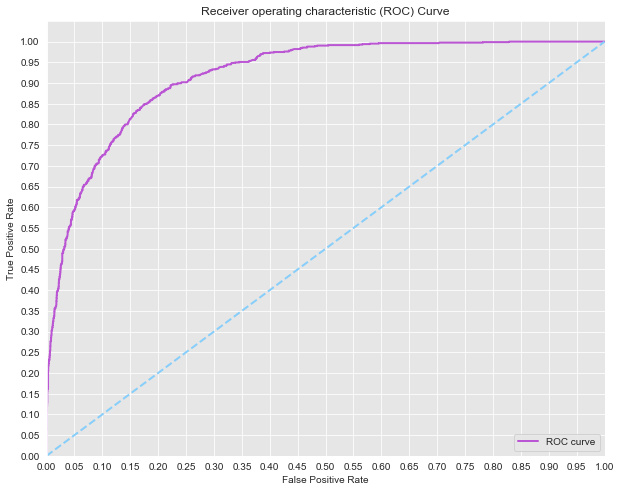

<Figure size 432x288 with 0 Axes>

In [69]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='mediumorchid',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='lightskyblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc_auc_curve.png')

In [130]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [139]:
evaluate_threshold(0.1)

Sensitivity: 0.9533492822966507
Specificity: 0.6369953673064196


In [71]:
print('Mean Random Forest Cross-Val Score (k=5):')
print(cross_val_score(best_forest, X, y, cv=5).mean())

Mean Random Forest Cross-Val Score (k=5):
0.8299316605927665


In [57]:
y_test.value_counts()

0    3022
1     836
Name: above_bk_mean, dtype: int64

Let's visualize a tree!

In [105]:
rf_tree_1 = best_forest.estimators_[10]

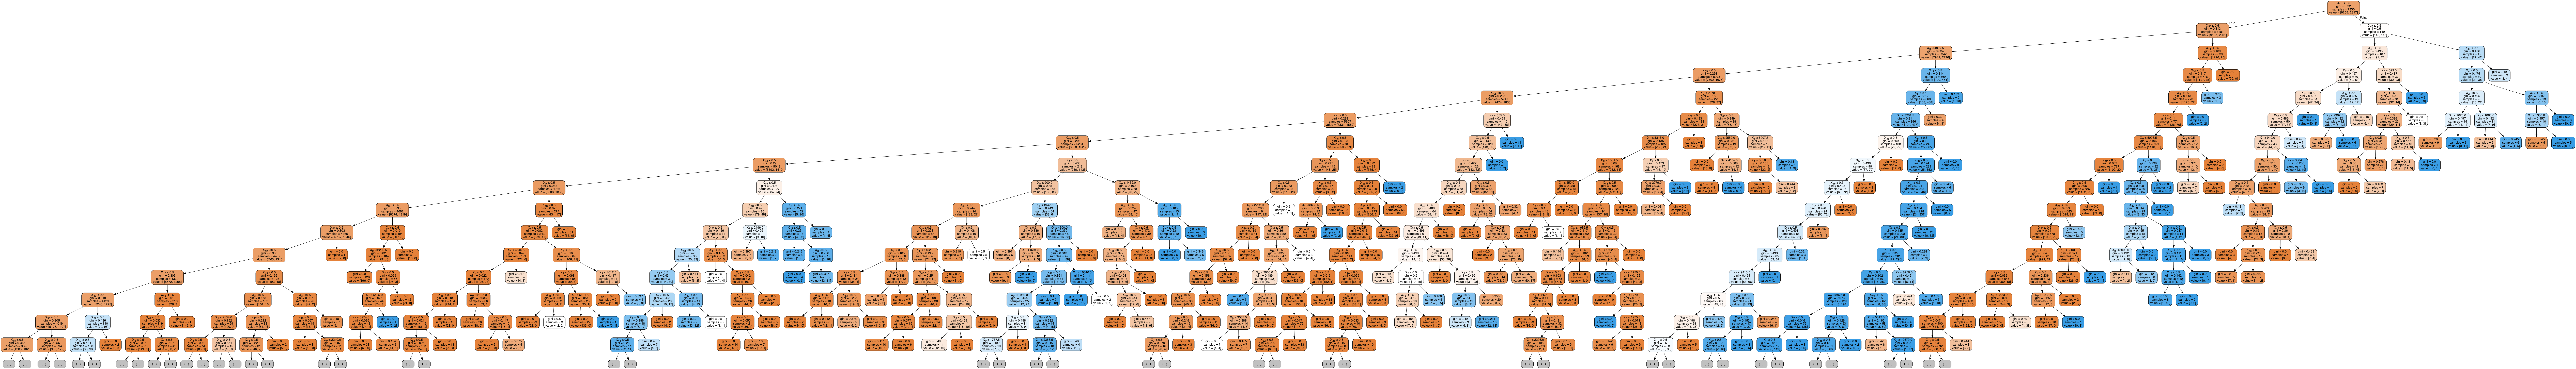

In [117]:
dot_data = StringIO()
export_graphviz(rf_tree_1, out_file=dot_data,  
                rounded=True, filled=True,
                special_characters=True, max_depth=15)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [122]:
kfold = KFold(n_splits=5, random_state=42)
cv_results = cross_val_score(best_forest, X_test, y_test, cv=kfold)
print(cv_results)

[0.86917098 0.84974093 0.87694301 0.86770428 0.8690013 ]


### Try entropy instead of gini?

In [123]:
ent_forest = RandomForestClassifier(criterion='entropy', n_estimators= 800, min_samples_split= 10, min_samples_leaf= 1, 
                                    max_features= 3, max_depth= 40, bootstrap= True, random_state=42)

In [124]:
ent_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=40, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [125]:
print(f'Training accuracy: {ent_forest.score(X_train, y_train)}')
print(f'Testing accuracy: {ent_forest.score(X_test, y_test)}')

Training accuracy: 0.9191151054268925
Testing accuracy: 0.8719543805080352


# XGBoost

In [38]:
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [39]:
print(f'Training accuracy: {clf.score(X_train, y_train)}')
print(f'Testing accuracy: {clf.score(X_test, y_test)}')

Training accuracy: 0.8739198064293121
Testing accuracy: 0.8610679108346293


In [40]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[2954   68]
 [ 468  368]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      3022
           1       0.84      0.44      0.58       836

    accuracy                           0.86      3858
   macro avg       0.85      0.71      0.75      3858
weighted avg       0.86      0.86      0.84      3858



Null Accuracy: 0.7833074131674442
Accuracy is :86.10679108346292
F1-Score is :0.5786163522012578
Precision Score is :0.8440366972477065
Recall Score is :0.44019138755980863

AUC is :0.71

Confusion Matrix
----------------
Confusion Matrix, without normalization
[[2954   68]
 [ 468  368]]


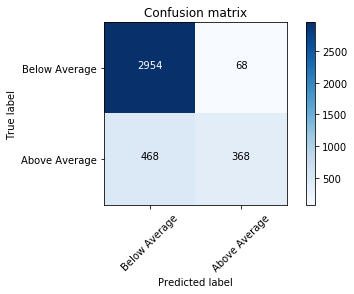

In [41]:
print_eval_metrics(y_test, pred, y)

### So this is bad, because it is giving me a lot more Type II errors, which is what I *don't* want!

## Playing with the 'magic' code

In [121]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
#testing models
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

LR: 0.864439 (0.005746)
KNN: 0.811040 (0.011489)
CART: 0.821411 (0.012519)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The defa

SVM: 0.779675 (0.013116)
XGB: 0.859771 (0.007680)


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: T

RF: 0.846291 (0.013139)
